In [0]:
import pandas as pd
import numpy as np

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop

from numpy import concatenate
from math import sqrt

import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d %H')

df=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data_total_imputed.csv", parse_dates=[['FECHA','HORA']], index_col=0, date_parser=parse)
df.index.name = 'date'
df.drop('Unnamed: 0', axis=1, inplace=True)
df=df.sort_index()
df

,NO2,O3,PM10,SO2,PROVINCIA,ESTACION,MES_Y_DIA,FESTIVO,PREC,PRES_MAX,PRES_MIN,RACHA,T_MAX,T_MED,T_MIN,VEL_MEDIA,ENTORNO
date,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.0,60.000000,12.000000,10.0,León,Ponferrada4,Jan 01,1,6.2,952.200000,943.000000,10.0,12.1,9.7,7.3,2.8,4
2014-01-01 00:00:00,8.0,58.000000,7.000000,3.0,Soria,Soria,Jan 01,1,9.6,894.200000,888.200000,10.0,5.8,4.6,3.5,3.3,1
2014-01-01 00:00:00,3.0,59.000000,13.000000,6.0,León,C.T.Compostilla-Cortiguera,Jan 01,1,6.2,952.200000,943.000000,10.0,12.1,9.7,7.3,2.8,3
2014-01-01 00:00:00,11.0,61.000000,3.000000,5.0,Segovia,Segovia 2,Jan 01,1,3.2,904.100000,898.000000,13.1,10.1,8.4,6.8,3.9,1
2014-01-01 00:00:00,1.0,55.000000,18.000000,1.0,León,C.T.Compostilla-Congosto,Jan 01,1,6.2,952.200000,943.000000,10.0,12.1,9.7,7.3,2.8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,11.0,50.552704,12.000000,1.0,Burgos,Burgos1,Dec 31,0,0.0,928.800000,926.800000,8.9,14.6,7.0,-0.5,3.3,1
2018-12-31 23:00:00,9.0,6.000000,21.000000,1.0,Burgos,Aranda de Duero 2,Dec 31,0,0.0,940.600000,938.300000,3.1,10.5,2.0,-6.5,0.6,1
2018-12-31 23:00:00,2.0,23.000000,16.183849,1.0,Soria,Muriel de la Fuente,Dec 31,0,0.0,906.900000,904.600000,2.8,19.4,8.0,-3.3,0.6,2


In [0]:
#urban: NO2, 3 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  # select predictors and tarjet (tarjet: NO2, pred: NO2, climate and festivos)
  values=values[:,[0, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('NO2 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('NO_2')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban1_2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban: O3, 3 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  # select predictors and tarjet (tarjet: NO2, pred: NO2, climate and festivos)
  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_3O3.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: PM10, 3 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  # select predictors and tarjet (tarjet: NO2, pred: NO2, climate and festivos)
  values=values[:,[2, 7b, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('PM10 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('PM_10')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_3PM10.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban: NO2, 2 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  # select predictors and tarjet (tarjet: NO2, pred: NO2, climate)
  values=values[:,[0, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('NO2 + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('NO_2')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_2NO2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: O3, 2 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O_3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_2O3.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: PM10, 2 predictores, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[2, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('PM10 + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('PM_10')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_2PM10.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: NO2, 1 predictor, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[0]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  #encoder = LabelEncoder()
  #values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  #reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('NO2; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('NO_2')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_1NO2.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: O3, 1 predictor, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  #encoder = LabelEncoder()
  #values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  #reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O_3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_1O3.csv')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#urban2: PM10, 1 predictor, 3 LSTM, 1 hora vista
urban1=["Salamanca5","Segovia 2","Zamora 2"]
n_epochs=[5, 20, 40]
batchsize=[5, 20, 50]
units=[20, 50, 100]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[2]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  #encoder = LabelEncoder()
  #values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  #reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('PM10; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('PM_10')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_urban2_1PM10.csv')

Output hidden; open in https://colab.research.google.com to view.

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 2s 50us/step - loss: 0.0138 - val_loss: 0.0114
Epoch 2/5
35040/35040 [==============================] - 1s 36us/step - loss: 0.0113 - val_loss: 0.0109
Epoch 3/5
35040/35040 [==============================] - 1s 35us/step - loss: 0.0108 - val_loss: 0.0102
Epoch 4/5
35040/35040 [==============================] - 1s 36us/step - loss: 0.0104 - val_loss: 0.0099
Epoch 5/5
35040/35040 [==============================] - 1s 35us/step - loss: 0.0099 - val_loss: 0.0084
Test RMSE: 16.659
Estadístico R_2: 0.655
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


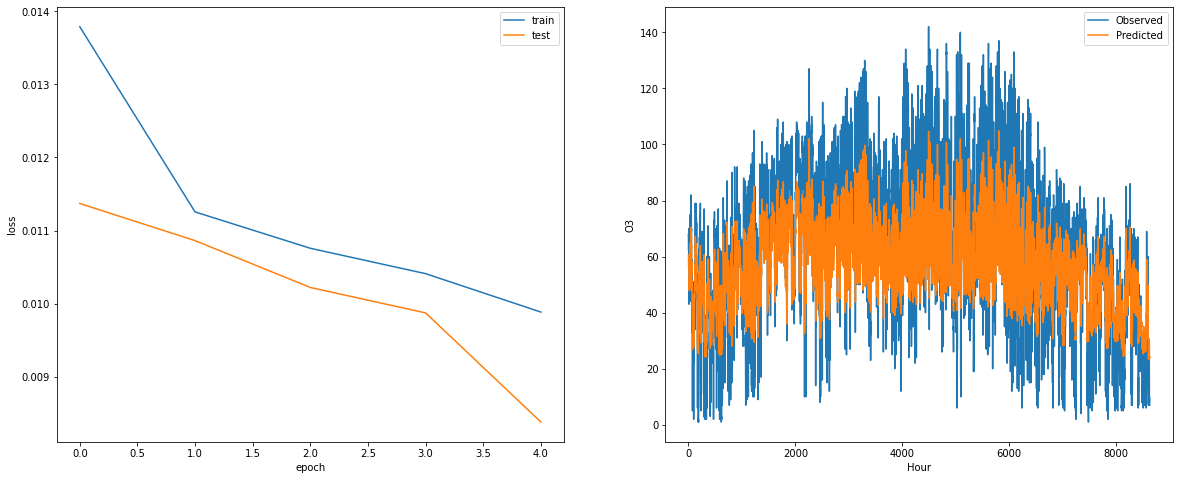

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  16.659271  0.654783
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  16.659271  0.654783


In [5]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_lstm1.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 2s 69us/step - loss: 0.0167 - val_loss: 0.0124
Epoch 2/5
35040/35040 [==============================] - 2s 53us/step - loss: 0.0118 - val_loss: 0.0102
Epoch 3/5
35040/35040 [==============================] - 2s 52us/step - loss: 0.0114 - val_loss: 0.0095
Epoch 4/5
35040/35040 [==============================] - 2s 52us/step - loss: 0.0105 - val_loss: 0.0080
Epoch 5/5
35040/35040 [==============================] - 2s 52us/step - loss: 0.0099 - val_loss: 0.0061
Test RMSE: 14.265
Estadístico R_2: 0.747
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


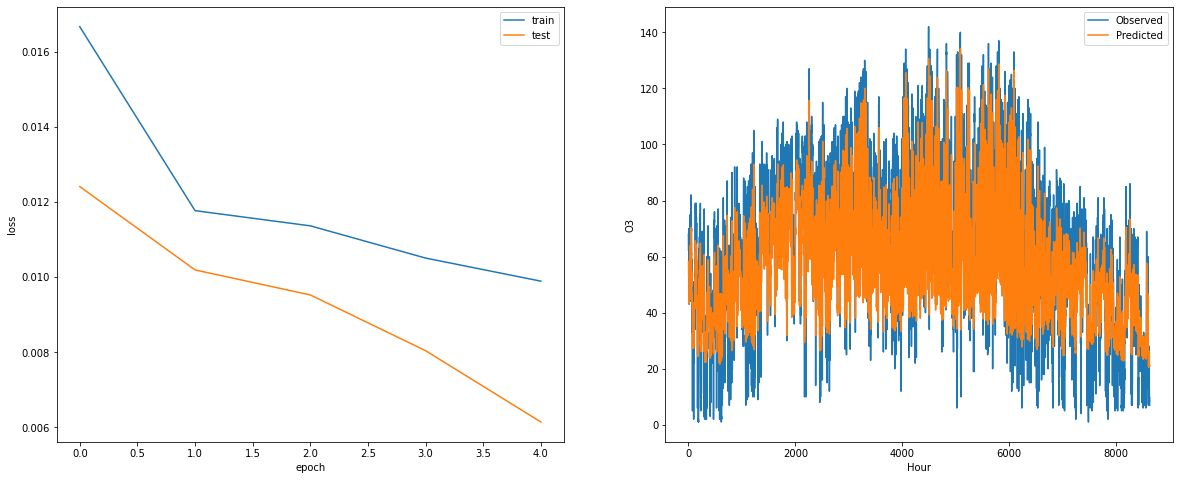

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  14.265158  0.746876
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  14.265158  0.746876


In [6]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_lstm2.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 4s 101us/step - loss: 0.0174 - val_loss: 0.0112
Epoch 2/5
35040/35040 [==============================] - 2s 70us/step - loss: 0.0122 - val_loss: 0.0092
Epoch 3/5
35040/35040 [==============================] - 2s 71us/step - loss: 0.0114 - val_loss: 0.0070
Epoch 4/5
35040/35040 [==============================] - 2s 71us/step - loss: 0.0106 - val_loss: 0.0060
Epoch 5/5
35040/35040 [==============================] - 2s 70us/step - loss: 0.0100 - val_loss: 0.0054
Test RMSE: 13.366
Estadístico R_2: 0.778
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


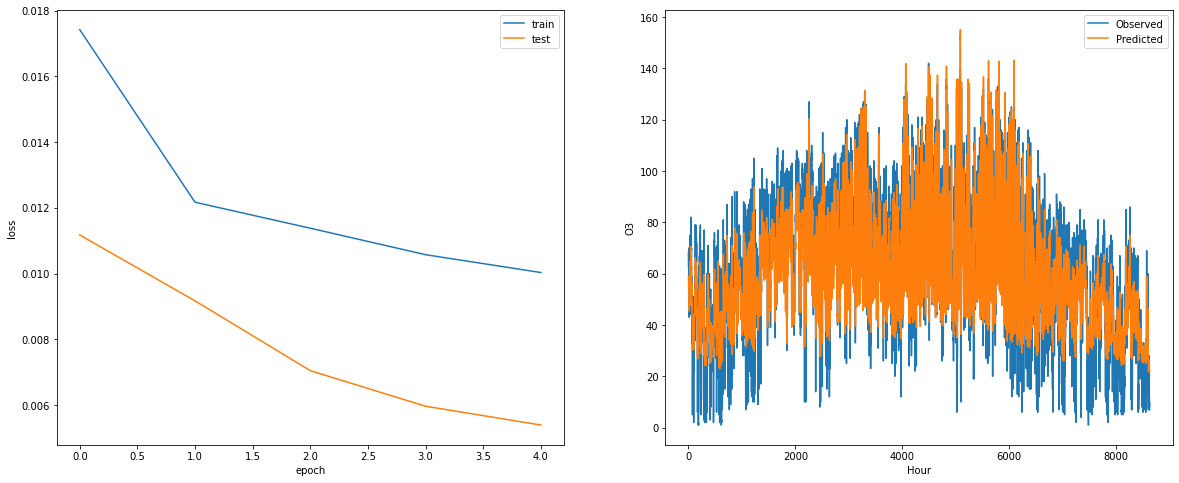

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  13.365786  0.777787
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  13.365786  0.777787


In [7]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_lstm3.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 4s 128us/step - loss: 0.0183 - val_loss: 0.0106
Epoch 2/5
35040/35040 [==============================] - 3s 89us/step - loss: 0.0121 - val_loss: 0.0065
Epoch 3/5
35040/35040 [==============================] - 3s 86us/step - loss: 0.0108 - val_loss: 0.0057
Epoch 4/5
35040/35040 [==============================] - 3s 86us/step - loss: 0.0100 - val_loss: 0.0057
Epoch 5/5
35040/35040 [==============================] - 3s 87us/step - loss: 0.0093 - val_loss: 0.0074
Test RMSE: 15.694
Estadístico R_2: 0.694
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


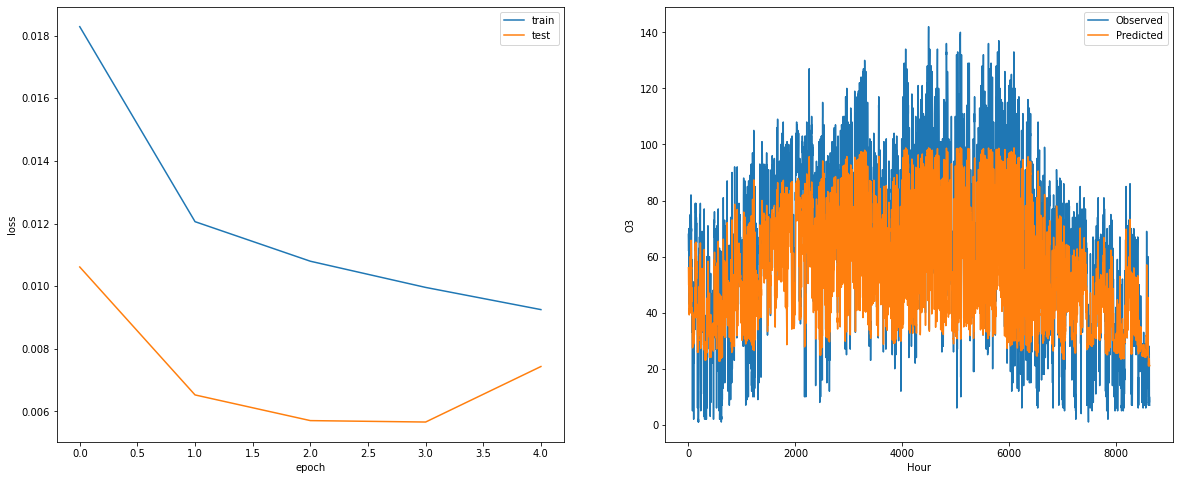

   Estacion  Numero epocas  Batch size  Unidades      RMSE        R2
0  Zamora 2              5          50        20  15.69352  0.693648
   Estacion  Numero epocas  Batch size  Unidades      RMSE        R2
0  Zamora 2              5          50        20  15.69352  0.693648


In [9]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_lstm4.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 6s 157us/step - loss: 0.0204 - val_loss: 0.0187
Epoch 2/5
35040/35040 [==============================] - 4s 106us/step - loss: 0.0130 - val_loss: 0.0064
Epoch 3/5
35040/35040 [==============================] - 4s 105us/step - loss: 0.0112 - val_loss: 0.0056
Epoch 4/5
35040/35040 [==============================] - 4s 104us/step - loss: 0.0102 - val_loss: 0.0069
Epoch 5/5
35040/35040 [==============================] - 4s 105us/step - loss: 0.0096 - val_loss: 0.0077
Test RMSE: 15.940
Estadístico R_2: 0.684
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


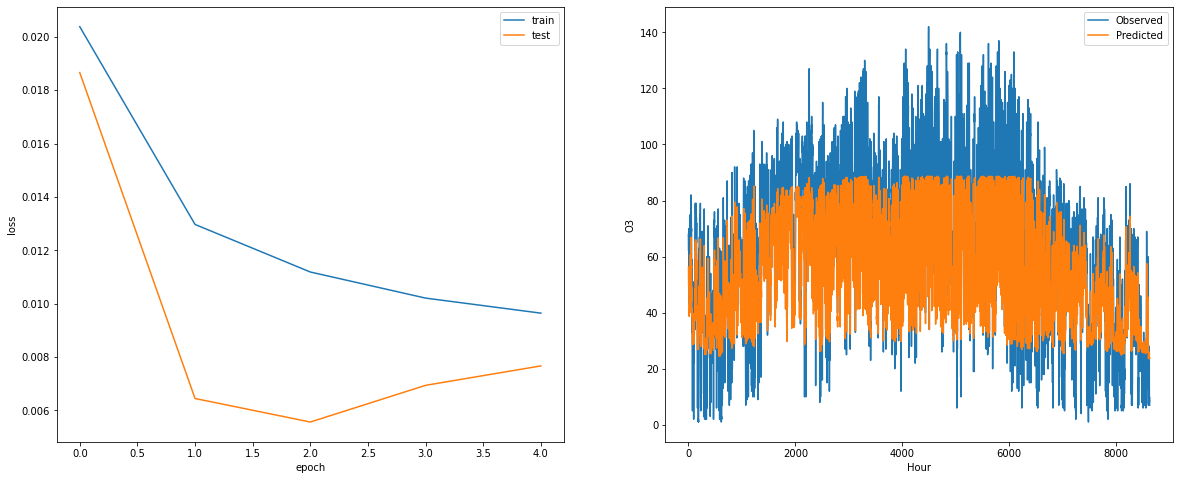

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  15.939551  0.683967
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  15.939551  0.683967


In [11]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(LSTM(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], return_sequences=True, dropout=0.2))
        model.add(LSTM(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_lstm5.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 2s 47us/step - loss: 0.0150 - val_loss: 0.0104
Epoch 2/5
35040/35040 [==============================] - 1s 39us/step - loss: 0.0112 - val_loss: 0.0108
Epoch 3/5
35040/35040 [==============================] - 1s 40us/step - loss: 0.0108 - val_loss: 0.0102
Epoch 4/5
35040/35040 [==============================] - 1s 39us/step - loss: 0.0104 - val_loss: 0.0096
Epoch 5/5
35040/35040 [==============================] - 1s 39us/step - loss: 0.0098 - val_loss: 0.0089
Test RMSE: 17.194
Estadístico R_2: 0.632
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


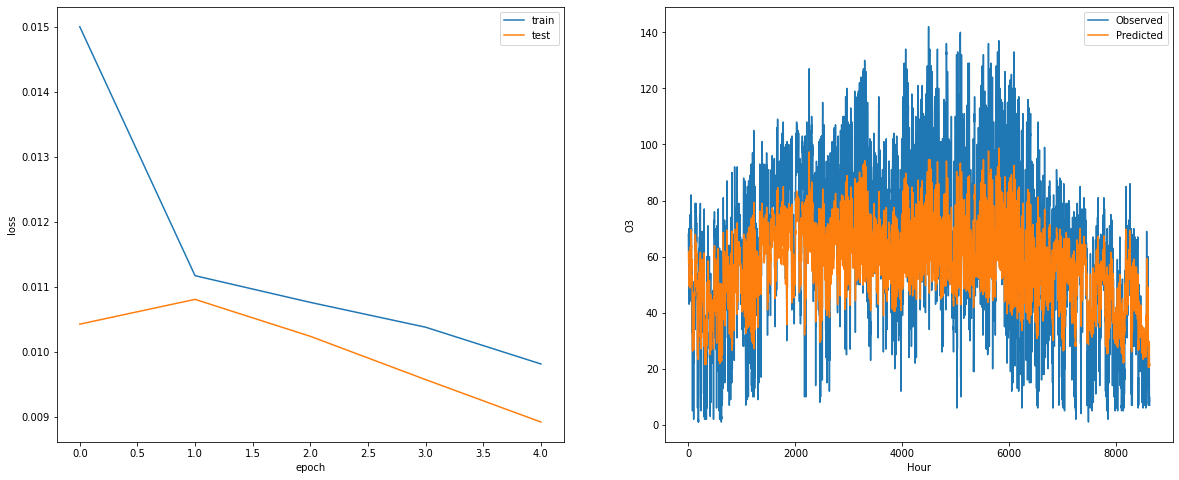

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  17.194161  0.632259
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  17.194161  0.632259


In [14]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(GRU(units[c], input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_gru1.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 3s 79us/step - loss: 0.0149 - val_loss: 0.0118
Epoch 2/5
35040/35040 [==============================] - 2s 59us/step - loss: 0.0118 - val_loss: 0.0096
Epoch 3/5
35040/35040 [==============================] - 2s 58us/step - loss: 0.0099 - val_loss: 0.0063
Epoch 4/5
35040/35040 [==============================] - 2s 60us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 5/5
35040/35040 [==============================] - 2s 62us/step - loss: 0.0081 - val_loss: 0.0075
Test RMSE: 15.809
Estadístico R_2: 0.689
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


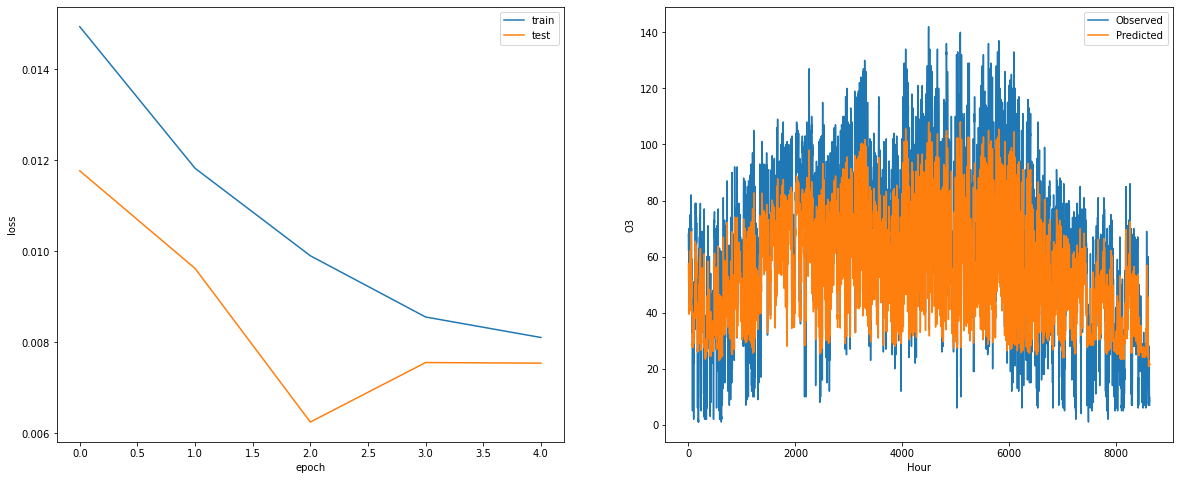

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  15.808631  0.689137
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  15.808631  0.689137


In [24]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(GRU(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_gru2.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 4s 114us/step - loss: 0.0152 - val_loss: 0.0120
Epoch 2/5
35040/35040 [==============================] - 3s 79us/step - loss: 0.0121 - val_loss: 0.0081
Epoch 3/5
35040/35040 [==============================] - 3s 78us/step - loss: 0.0101 - val_loss: 0.0063
Epoch 4/5
35040/35040 [==============================] - 3s 79us/step - loss: 0.0090 - val_loss: 0.0075
Epoch 5/5
35040/35040 [==============================] - 3s 80us/step - loss: 0.0083 - val_loss: 0.0085
Test RMSE: 16.736
Estadístico R_2: 0.652
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


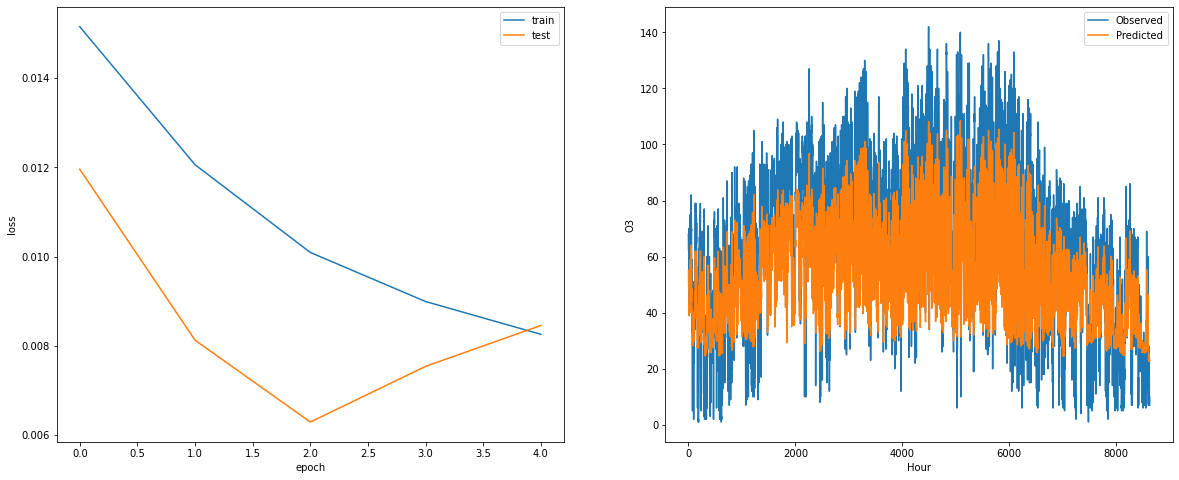

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  16.735837  0.651602
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  16.735837  0.651602


In [21]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(GRU(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(GRU(units[c],return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_gru3.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 5s 144us/step - loss: 0.0156 - val_loss: 0.0109
Epoch 2/5
35040/35040 [==============================] - 3s 99us/step - loss: 0.0119 - val_loss: 0.0080
Epoch 3/5
35040/35040 [==============================] - 3s 98us/step - loss: 0.0103 - val_loss: 0.0071
Epoch 4/5
35040/35040 [==============================] - 3s 97us/step - loss: 0.0091 - val_loss: 0.0080
Epoch 5/5
35040/35040 [==============================] - 3s 99us/step - loss: 0.0085 - val_loss: 0.0104
Test RMSE: 18.599
Estadístico R_2: 0.570
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


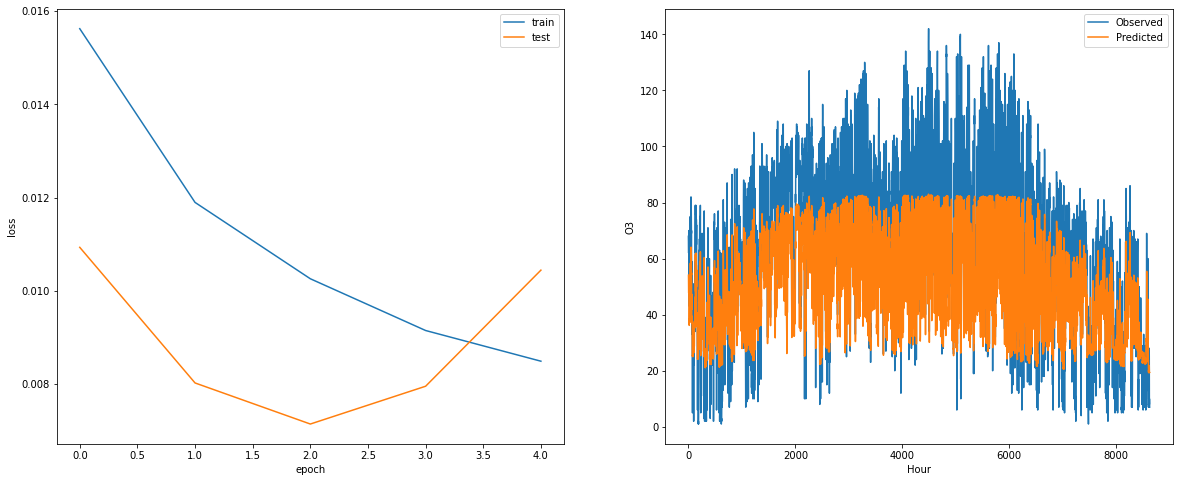

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  18.598685  0.569726
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  18.598685  0.569726


In [17]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(GRU(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(GRU(units[c],return_sequences=True, dropout=0.2))
        model.add(GRU(units[c],return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_gru4.csv')

Train on 35040 samples, validate on 8628 samples
Epoch 1/5
35040/35040 [==============================] - 6s 176us/step - loss: 0.0163 - val_loss: 0.0127
Epoch 2/5
35040/35040 [==============================] - 4s 117us/step - loss: 0.0120 - val_loss: 0.0073
Epoch 3/5
35040/35040 [==============================] - 4s 116us/step - loss: 0.0106 - val_loss: 0.0063
Epoch 4/5
35040/35040 [==============================] - 4s 117us/step - loss: 0.0097 - val_loss: 0.0089
Epoch 5/5
35040/35040 [==============================] - 4s 116us/step - loss: 0.0089 - val_loss: 0.0128
Test RMSE: 20.553
Estadístico R_2: 0.475
O3 + festivo + clima; Ciudad: Zamora 2 Epochs: 5 Batch size: 50 Units: 20


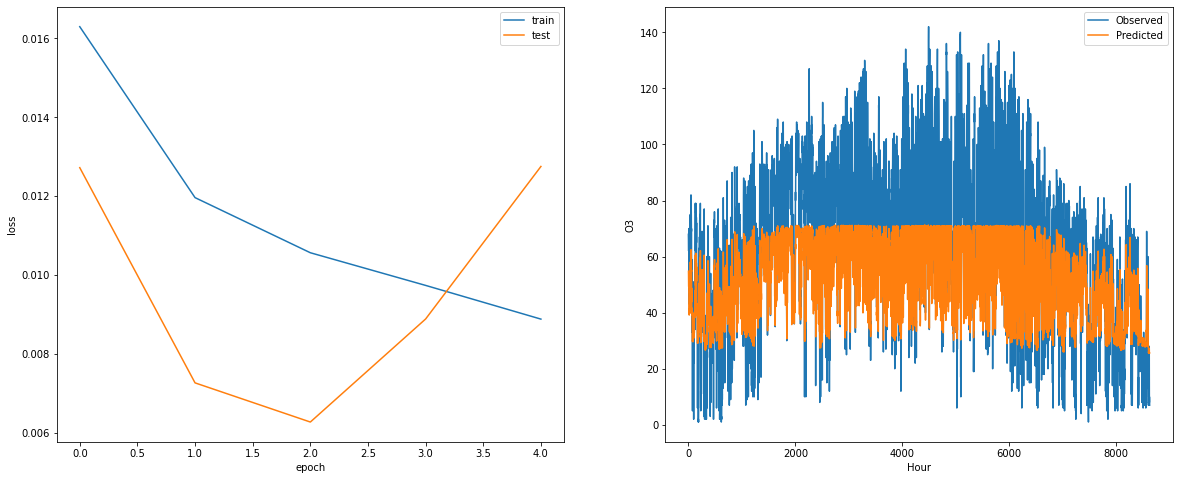

   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  20.553255  0.474538
   Estacion  Numero epocas  Batch size  Unidades       RMSE        R2
0  Zamora 2              5          50        20  20.553255  0.474538


In [18]:
urban1=["Zamora 2"]
n_epochs=[5]
batchsize=[50]
units=[20]

list_n_epochs=[]
list_batchsize=[]
list_units=[]
list_rmse=[]
list_r2=[]
list_estacion=[]

#urban 
for i in range(len(urban1)):
  df_urban=df.loc[:,'ESTACION'] == urban1[i]
  df_urban=df.loc[df_urban]
  values = df_urban.values

  values=values[:,[1, 7, 8, 9, 10, 11, 12, 13, 14, 15]]



  def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace=True)
    return agg

  #encod.
  encoder = LabelEncoder()
  values[:,1] = encoder.fit_transform(values[:,1])

  values = values.astype('float32')

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 1, 1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

  values = reframed.values
  #train, test sets
  n_train_hours = 4 * 365 * 24
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

 
  for a in range(len(n_epochs)):
    for b in range(len(batchsize)):
      for c in range(len(units)):

        #model 
        model = Sequential()
        model.add(GRU(units[c], input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], return_sequences=True, dropout=0.2))
        model.add(GRU(units[c], dropout=0.2))
        model.add(Dense(1))
        model.compile(optimizer = RMSprop(), loss = "mean_squared_error")
        # fit network
        history = model.fit(train_X, train_y, epochs=n_epochs[a], batch_size=batchsize[b], validation_data=(test_X, test_y), shuffle=False)


        # make a prediction
        yhat = model.predict(test_X)
        test_X_fin = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X_fin[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y_fin = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y_fin, test_X_fin[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print ('Estadístico R_2: %.3f' % r2)

        list_n_epochs.append(n_epochs[a])
        list_batchsize.append(batchsize[b])
        list_units.append(units[c])
        list_rmse.append(rmse)
        list_r2.append(r2)
        list_estacion.append(urban1[i])

        print('O3 + festivo + clima; Ciudad:', urban1[i],'Epochs:', n_epochs[a], 'Batch size:', batchsize[b], 'Units:', units[c])

        #plots
        fig=plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(inv_y, label='Observed')
        plt.plot(inv_yhat, label='Predicted')
        plt.xlabel('Hour')
        plt.ylabel('O3')
        plt.legend(loc="upper right")

        plt.show()

df_fin = pd.DataFrame({"Estacion": list_estacion, "Numero epocas": list_n_epochs, "Batch size": list_batchsize,
                   "Unidades": list_units, "RMSE": list_rmse, "R2": list_r2})

print(df_fin.head(50))
print(df_fin.tail(50))
df_fin.to_csv('/content/gdrive/My Drive/Colab Notebooks/df_zamora_3O3_gru5.csv')